<a href="https://colab.research.google.com/github/cristina-ramos/INFO/blob/main/Assignments/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gofer-grader

In [ ]:
from datascience import *
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plots.style.use('fivethirtyeight')
from gofer.ok import check

In [ ]:
df = pd.read_csv('/content/crime_rates.csv')
df1 = df[['State', 'Year', 'Population', 'Murder Rate']]

In [ ]:
murder_rates = Table.read_table('/content/crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


In [ ]:
#Alaska
ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
#Minnesota
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')
ak_mn = ak.join("Year", mn)
ak_mn

Year,Murder rate in Alaska,Murder rate in Minnesota
1960,10.2,1.2
1961,11.5,1
1962,4.5,0.9
1963,6.5,1.2
1964,10.4,1.4
1965,6.3,1.4
1966,12.9,2.2
1967,9.6,1.6
1968,10.5,2.2
1969,10.6,1.9


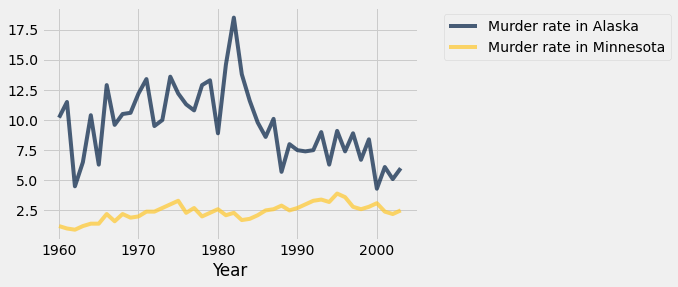

In [ ]:
ak_mn.plot("Year")

array(['California', 'Mississippi', 'Texas', 'New York', 'Louisiana'],
      dtype='<U14')

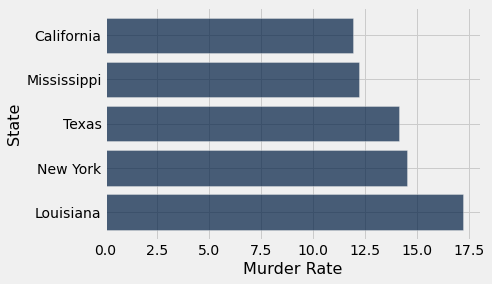

In [ ]:
def most_murderous(year):
  data_for_year = murder_rates.where("Year", year)
  sorted_data = data_for_year.sort("Murder Rate", descending = True)
  top_5 = sorted_data.take(np.arange(5)).sort("Murder Rate")
  top_5.barh('State', 'Murder Rate')
  return top_5.column('State')

  
most_murderous(1990)

In [ ]:
ca = murder_rates.where('State', are.equal_to('California'))
ca

State,Year,Population,Murder Rate
California,1960,"15,717,204",3.9
California,1961,"16,397,000",3.7
California,1962,"16,970,000",3.9
California,1963,"17,590,000",3.8
California,1964,"18,084,000",4.1
California,1965,"18,602,000",4.7
California,1966,"18,918,000",4.6
California,1967,"19,153,000",5.4
California,1968,"19,221,000",6
California,1969,"19,443,000",7.1


In [ ]:
ca_change = (ca.where('Year', 1988).column(3).item(0)*ca.where('Year', 1988).column(2).item(0)-ca.where('Year', 1975).column(3).item(0)*ca.where('Year', 1975).column(2).item(0))/100000
np.round(ca_change)

726.0

In [ ]:
def diff_n(values, n):
  return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

array([  99,  990, 9900])

In [ ]:
def twoyear_changes(rates):
  return np.count_nonzero(diff_n(rates, 2)>0) - np.count_nonzero(diff_n(rates, 2)<0)

print('Alaska:',  twoyear_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:',  twoyear_changes(mn.column('Murder rate in Minnesota')))

Alaska: -5
Minnesota: 6


In [ ]:
states = murder_rates.sort("State", distinct=True).column(0)
change = make_array()
for i in np.arange(len(states)):
  c = twoyear_changes(murder_rates.where("State", states[i]).column(3))
  change = np.append(change, c)

changes_by_state = Table().with_columns('State', states, 'Murder Rate twoyear_changes', change)
changes_by_state

State,Murder Rate twoyear_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


In [ ]:
total_changes = sum(change)
print("Total Changes Across All States and Years:", total_changes)

Total Changes Across All States and Years: 45.0


In [ ]:
pds = make_array()
for i in np.arange(len(states)):
  pd = murder_rates.where("State", states[i]).num_rows-2
  pds = np.append(pds, pd)

num_changes = sum(pds)
num_changes

2100.0

In [ ]:
uniform = Table().with_columns(
 "Change", make_array('Increase', 'Decrease'),
 "Chance", make_array(0.5, 0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,54
Decrease,0.5,46


In [ ]:
def simulate_under_null(num_chances_to_change):
  return uniform.sample_from_distribution('Chance', 100).column(2).item(0)-uniform.sample_from_distribution('Chance', 100).column(2).item(1)

uniform_samples = make_array()
for i in np.arange(5000):
  uniform_samples = np.append(uniform_samples, simulate_under_null(...))

simulated_changes = Table().with_column('Test statistic under null', uniform_samples)
simulated_changes

Test statistic under null
-1
2
12
-3
4
-3
0
4
10
3


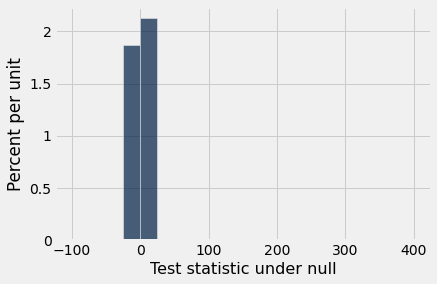

In [ ]:
simulated_changes.hist(0, bins=np.arange(-100, 400+25, 25))

In [ ]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')

def death_penalty_1971(state):
  return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(death_penalty_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


In [ ]:
death_penalty_states = death_penalty.where('Death Penalty', True).column(0)
death_penalty_murder_rates = murder_rates.where('State', are.contained_in(death_penalty_states))
death_penalty_murder_rates

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


In [ ]:
t = death_penalty_murder_rates.where('Year', are.between(1971,1974))
states = t.sort('State', distinct = True).column(0)
stats = make_array()
for i in np.arange(len(states)):
  s = diff_n(t.where('State',states[i]).column(3), 2)
  stats = np.append(stats,s)

changes_72 = np.count_nonzero(stats>0)- np.count_nonzero(stats<0)
print('Test statistic from 1971 to 1973:', changes_72)

Test statistic from 1971 to 1973: 22


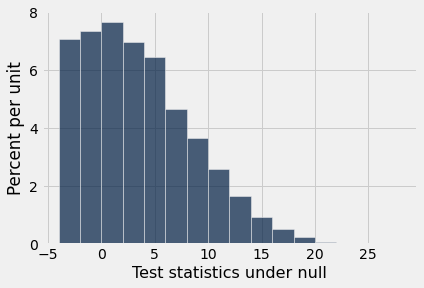

In [ ]:
samples = make_array()
for i in np.arange(10000):
  sample = simulate_under_null(len(states))
  samples = np.append(samples, sample)

Table().with_column('Test statistics under null', samples).hist(bins=np.arange(-4, 28+2, 2))

In [ ]:
p = np.count_nonzero(samples>=test_stat_72)/10000
p

0.0009

In [ ]:
def run_test(rates, start_year):
  end_year = start_year + 2
  observed_test_statistic = sum(rates.where('Year', are.between_or_equal_to(start_year, end_year)).select('State', 'Murder Rate').group('State', twoyear_changes).column(1))
  print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
  num_states = rates.group('State').num_rows

  samples = []
  for i in np.arange(5000):
    sample = simulate_under_null(num_states)
    samples = np.append(samples, sample)

  if observed_test_statistic > 0:
    return sum(samples >= observed_test_statistic) / len(samples)
  elif observed_test_statistic < 0:
    return sum(samples <= observed_test_statistic) / len(samples)

run_test(death_penalty_murder_rates, 1971)

Test statistic 1971 to 1973 : 22


0.0012

In [ ]:
years = murder_rates.sort('Year', distinct=True).column('Year')
death = murder_rates.where('State', are.contained_in(states)).group('Year', np.mean).column(3)
no_death = murder_rates.where('State', are.contained_in(non_death_penalty_states)).group('Year', np.mean).column(3)
average_murder_rates = Table().with_columns('Year', years, 'Death penalty states', death, 'No death penalty states', no_death)
average_murder_rates

Year,Death penalty states,No death penalty states
1960,5.27955,3.55
1961,4.77727,3.68333
1962,4.61591,2.33333
1963,4.61364,2.75
1964,4.71136,3.4
1965,4.82727,3.18333
1966,5.43182,4.51667
1967,5.875,3.73333
1968,6.27045,4.73333
1969,6.50227,4.73333


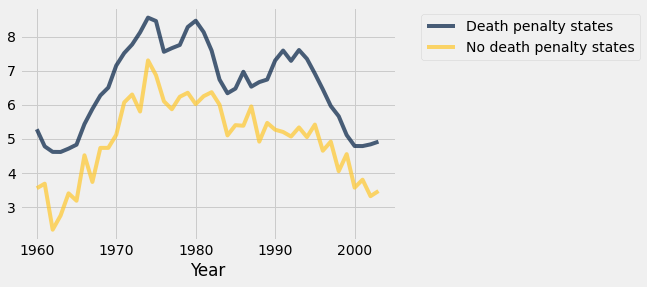

In [ ]:
average_murder_rates.plot('Year')